# The South Pole Telescope "low-$\ell$" Likelihood

This plugin implements the South Pole Telescope likelihood from [Story et al. (2012)](http://arxiv.org/abs/1210.7231) and [Keisler et al. (2011)](http://arxiv.org/abs/1105.3182). The data comes included with this plugin and was downloaded from [here](http://pole.uchicago.edu/public/data/story12/) and [here](http://pole.uchicago.edu/public/data/keisler11/), respectively.

You can choose which likelihood to use by specifying `which='s12'` or `which='k11'` when you initialize the plugin. 

The plugin also supports specifying an $\ell_{\rm min}$, $\ell_{\rm max}$, or dropping certain data bins.

[API](../../../autodoc/cosmoslik_plugins.likelihoods.spt_lowl)

See also the [API](../../../autodoc/cosmoslik_plugins.likelihoods.spt_lowl.html) documentation. 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from cosmoslik import *

## Basic Script

Here's a script which runs a basic SPT-only chain:

In [3]:
class spt(SlikPlugin):

    def __init__(self, **kwargs):
        super().__init__()
        self.cosmo = models.cosmology("lcdm")
        self.spt_lowl = likelihoods.spt_lowl(**kwargs)
        self.cmb = models.camb(lmax=4000)
        self.sampler = samplers.metropolis_hastings(self)

    def __call__(self):
        return self.spt_lowl(self.cmb(**self.cosmo))

Four sampled parameters, one for calibration and three for foregrounds, come by default with the SPT plugin:

In [4]:
spt().spt_lowl.find_sampled().keys()

odict_keys(['cal', 'egfs.Acl', 'egfs.Aps', 'egfs.Asz'])

The plugin has a convenience method for plotting the data and current model:

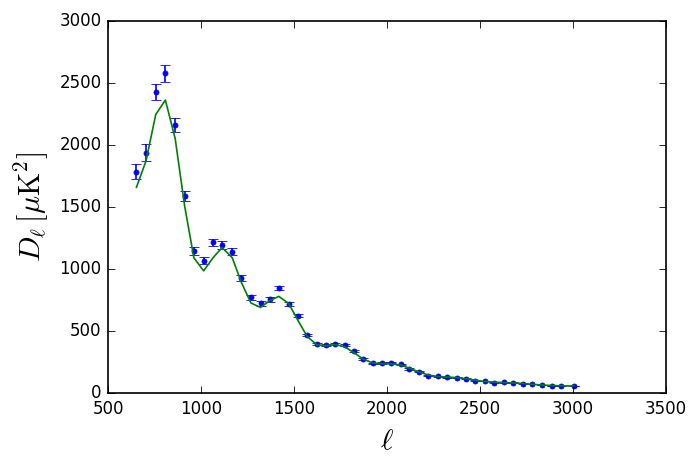

In [5]:
s = Slik(spt(which='s12'))
lnl, e = s.evaluate(**s.get_start())
e.spt_lowl.plot()

Or you can plot the "k11" bandpowers. You can see they're less constraining.

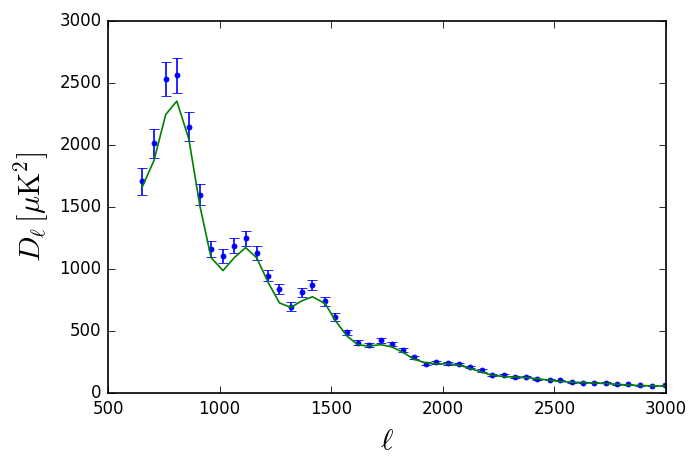

In [6]:
s = Slik(spt(which='k11'))
lnl, e = s.evaluate(**s.get_start())
e.spt_lowl.plot()

## Choosing subsets of data

You can also set some $\ell$-limits,

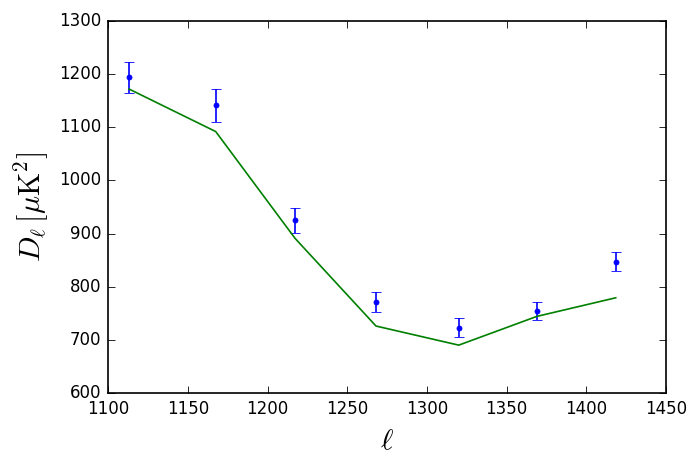

In [7]:
s = Slik(spt(which='s12',lmin=1000,lmax=1500))
lnl, e = s.evaluate(**s.get_start())
e.spt_lowl.plot()

Or drop some individual data points (by bin index),

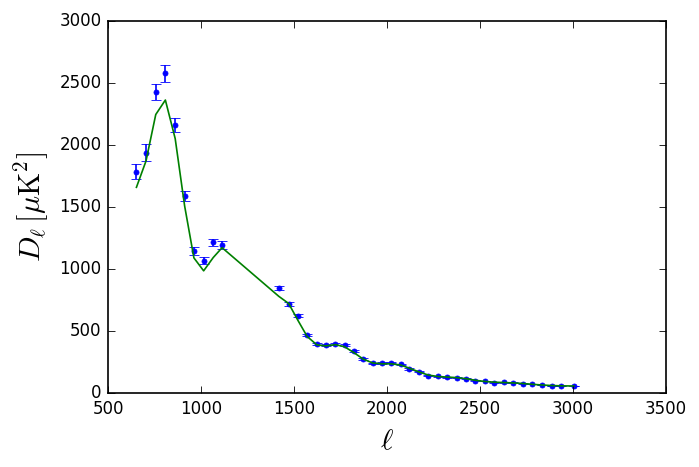

In [8]:
s = Slik(spt(which='s12',drop=range(10,15)))
lnl, e = s.evaluate(**s.get_start())
e.spt_lowl.plot()

## Calibration parameter

The calibration parameter is called `cal` and defined so it multiplies the data bandpowers. For "s12" it comes by default with a prior $1 \pm 0.026$. You can't use it for "k11" because this likelihood has the calibration pre-folded into the covariance. 

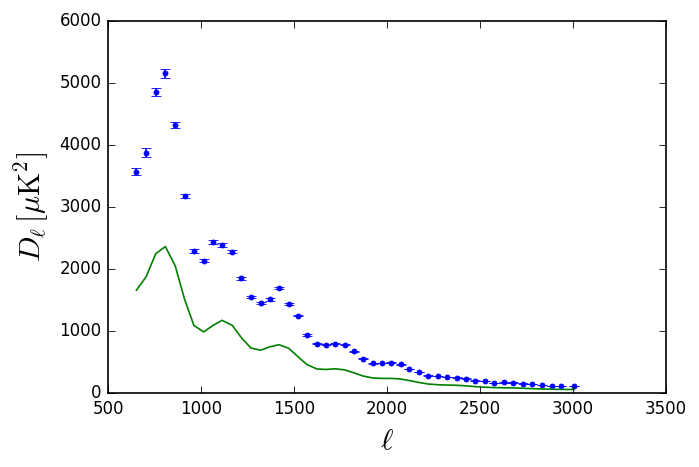

In [9]:
s = Slik(spt(which='s12',cal=2))
lnl, e = s.evaluate(**s.get_start())
e.spt_lowl.plot()

## Foreground model

By default the foreground model is the one used in the Story/Keisler et al. papers (same for both). There's an option to `plot` which shows you the CMB and foreground components separately so you can see it. 

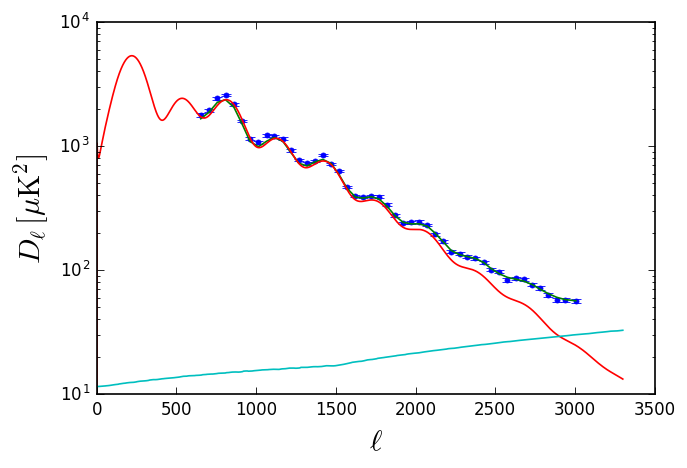

In [10]:
s = Slik(spt(which='s12'))
lnl, e = s.evaluate(**s.get_start())
e.spt_lowl.plot(show_comps=True)
yscale('log')

The foreground model is taken from the `spt_lowl.egfs` attribute which is expected to be a function which can be called with parameters `lmax` to specify the length of the array returned, and `egfs_specs` which provides some info about frequencies/fluxcut of the SPT bandpowers for more advanced foreground models. You can customize this by attaching your own callable function to `spt_lowl.egfs` when you call `__init__`, or passing something in during `__call__`. 

For example, say we wanted a Poisson-only foreground model, we could write the script like so:

In [11]:
class spt_myfgs(SlikPlugin):

    def __init__(self):
        super().__init__()
        self.cosmo = models.cosmology("lcdm")   
        self.spt_lowl = likelihoods.spt_lowl(egfs=None) #turn off default model & params
        self.Aps = param(start=30, scale=10, min=0) #add our own sampled parameter here
        self.cmb = models.camb(lmax=4000)
        self.sampler = samplers.metropolis_hastings(self)

    def __call__(self):
        return self.spt_lowl(self.cmb(**self.cosmo),
                            egfs=lambda lmax,**_: self.Aps * (arange(lmax)/3000.)**2) #compute our foregroud model

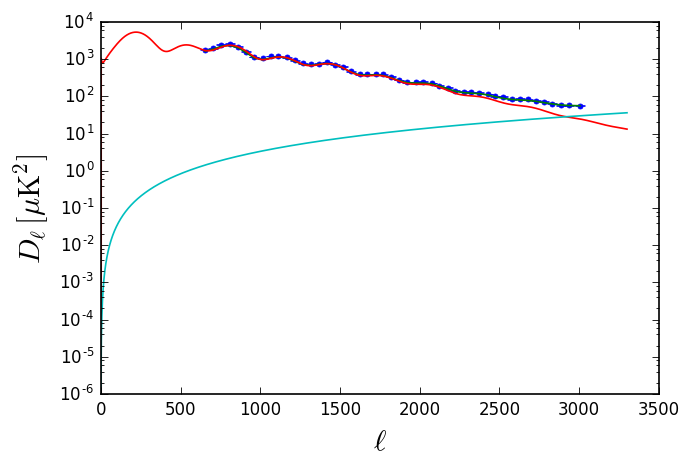

In [12]:
s = Slik(spt_myfgs())
lnl, e = s.evaluate(**s.get_start())
e.spt_lowl.plot(show_comps=True)
yscale("log")